Lets strart getting the necessary packages

In [5]:
# # backtest platform:
# !pip install vectorbt 
# # interact with Binance api:
# !pip install python-binance 
# # technical indicators library:
# !pip install pandas-ta

import pandas as pd
import numpy as np
import vectorbt as vbt
import matplotlib.pyplot as plt

Now we will fetch some historical data from Yahoo Finance, VectorBt includes a wrapper to fetch and join the data in a single object.
This data will be the 1 day frequecy form years 2018 to 2021.

In [9]:
tickers = ['ETHBTC', 'ADABTC', 'ETCBTC', 'LTCBTC']

df = yf_data = vbt.BinanceData.download(
  tickers,
  start='01/07/2019 UTC',
  end='01/01/2021 UTC',
  interval='1d'
  )

2019-01-07 00:00:00+00:00 - 2020-12-31 00:00:00+00:00: : 2it [00:01,  1.13it/s]
2019-01-07 00:00:00+00:00 - 2020-12-31 00:00:00+00:00: : 2it [00:01,  1.16it/s]
2019-01-07 00:00:00+00:00 - 2020-12-31 00:00:00+00:00: : 2it [00:01,  1.14it/s]
2019-01-07 00:00:00+00:00 - 2020-12-31 00:00:00+00:00: : 2it [00:01,  1.11it/s]


Now lets define our indicators and its inputs.

<AxesSubplot:xlabel='Open time'>

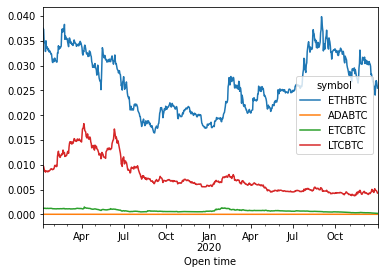

In [65]:
closing_prices = df['Close'].get()
high_prices = df['High'].get()
low_prices = df['Low'].get()

rsi= vbt.pandas_ta('RSI').run(closing_prices, 2)
ma200 = vbt.MA.run(closing_prices, 200)

#checking how this looks
closing_prices.plot()


The rules for long trades are: if price action is above it's 200ma and RSI value is below 5, exit when RSI is above 60.
The rules for short trades are: if price action is bellow it's 200ma and RSI value is above 95, exit when RSI is below 40.

The following code will create 4 different dataframes with timestamps and boolean values.



In [66]:
long_entries = rsi.rsi_below(10) & ma200.ma_below(closing_prices)
long_exits = rsi.rsi_above(60)
short_entries = rsi.rsi_above(90) & ma200.ma_above(closing_prices)
short_exits = rsi.rsi_below(40)

long_entries['ETHBTC']

rsi_length,2
ma_window,200
Open time,
2019-01-07 00:00:00+00:00,False
2019-01-08 00:00:00+00:00,False
2019-01-09 00:00:00+00:00,False
2019-01-10 00:00:00+00:00,False
2019-01-11 00:00:00+00:00,False
...,...
2020-12-27 00:00:00+00:00,False
2020-12-28 00:00:00+00:00,False


It's time to execute the portfolio calculations.

In [67]:
# kwargs = dict(fees=0.001, freq='1D')

portfolio = vbt.Portfolio.from_signals(
    close = closing_prices,
    entries = long_entries,
    exits = long_exits,
    short_entries=short_entries,
    short_exits=short_exits,
    init_cash=[10000, 10000, 10000, 10000],
    fees=0.001, freq='1D')

We will grab the records table and join it with the indicators we want to include to vizualise if the market volatility is positively correlated with PnL (profit and loss).

In [50]:

records = portfolio.trades.records_readable
print(records.columns)
atr7= vbt.ATR.run(high_prices, low_prices, closing_prices, 7).atr
atr60= vbt.ATR.run(high_prices, low_prices, closing_prices, 60).atr
rsi2= rsi.rsi


Index(['Exit Trade Id', 'Column', 'Size', 'Entry Timestamp', 'Avg Entry Price',
       'Entry Fees', 'Exit Timestamp', 'Avg Exit Price', 'Exit Fees', 'PnL',
       'Return', 'Direction', 'Status', 'Position Id'],
      dtype='object')


Les assamble some info to get the analysis.

In [51]:
df_cd = pd.merge(records, atr60, how='inner', left_on='Entry Timestamp', right_index= True )
df_cd['Column2'] = df_cd['Column'].str.get(2)
df_cd['atr60'] = np.where(df_cd['Column2'] == 'ETHBTC', df_cd[(60, 'ETHBTC')], 0)
df_cd['atr60'] = np.where(df_cd['Column2'] == 'ADABTC', df_cd[(60, 'ADABTC')], df_cd['atr60'])
df_cd['atr60'] = np.where(df_cd['Column2'] == 'LTCBTC', df_cd[(60, 'LTCBTC')], df_cd['atr60'])
df_cd['atr60'] = np.where(df_cd['Column2'] == 'ETCBTC', df_cd[(60, 'ETCBTC')], df_cd['atr60'])

df_cd = pd.merge(df_cd, atr7, how='inner', left_on='Entry Timestamp', right_index= True )
df_cd['atr7'] = np.where(df_cd['Column2'] == 'ETHBTC', df_cd[(7, 'ETHBTC')], 0)
df_cd['atr7'] = np.where(df_cd['Column2'] == 'ADABTC', df_cd[(7, 'ADABTC')], df_cd['atr7'])
df_cd['atr7'] = np.where(df_cd['Column2'] == 'LTCBTC', df_cd[(7, 'LTCBTC')], df_cd['atr7'])
df_cd['atr7'] = np.where(df_cd['Column2'] == 'ETCBTC', df_cd[(7, 'ETCBTC')], df_cd['atr7'])

df_cd = pd.merge(df_cd, rsi2, how='inner', left_on='Entry Timestamp', right_index= True )
df_cd['rsi2'] = np.where(df_cd['Column2'] == 'ETHBTC', df_cd[(2, 'ETHBTC')], 0)
df_cd['rsi2'] = np.where(df_cd['Column2'] == 'ADABTC', df_cd[(2, 'ADABTC')], df_cd['rsi2'])
df_cd['rsi2'] = np.where(df_cd['Column2'] == 'LTCBTC', df_cd[(2, 'LTCBTC')], df_cd['rsi2'])
df_cd['rsi2'] = np.where(df_cd['Column2'] == 'ETCBTC', df_cd[(2, 'ETCBTC')], df_cd['rsi2'])

df_cd['atr_7-60'] = df_cd['atr7'] / df_cd['atr60'] # Average True Range from last 7 days vs last 60 days
df_cd['atr%'] = df_cd["atr7"] / df_cd["Avg Exit Price"] * 100
df_cd

C:\Users\JUANPA~1\AppData\Local\Temp/ipykernel_2252/1098100650.py:1: FutureWarning: merging between different levels is deprecated and will be removed in a future version. (1 levels on the left, 2 on the right)
  df_cd = pd.merge(records, atr60, how='inner', left_on='Entry Timestamp', right_index= True )
C:\Users\JUANPA~1\AppData\Local\Temp/ipykernel_2252/1098100650.py:8: FutureWarning: merging between different levels is deprecated and will be removed in a future version. (1 levels on the left, 2 on the right)
  df_cd = pd.merge(df_cd, atr7, how='inner', left_on='Entry Timestamp', right_index= True )
C:\Users\JUANPA~1\AppData\Local\Temp/ipykernel_2252/1098100650.py:14: FutureWarning: merging between different levels is deprecated and will be removed in a future version. (1 levels on the left, 2 on the right)
  df_cd = pd.merge(df_cd, rsi2, how='inner', left_on='Entry Timestamp', right_index= True )


,Exit Trade Id,Column,Size,Entry Timestamp,Avg Entry Price,Entry Fees,Exit Timestamp,Avg Exit Price,Exit Fees,PnL,...,"(7, ETCBTC)","(7, LTCBTC)",atr7,"(2, ETHBTC)","(2, ADABTC)","(2, ETCBTC)","(2, LTCBTC)",rsi2,atr_7-60,atr%
0,0,"(200, 2, ETHBTC)",4.504265e+05,2019-07-25 00:00:00+00:00,0.022179,9.990010,2019-07-27 00:00:00+00:00,0.021871,9.851279,118.890082,...,0.000028,0.000548,0.000883,92.050521,58.103273,39.202956,49.459090,92.050521,0.726234,4.039184
1,1,"(200, 2, ETHBTC)",5.793330e+05,2019-09-08 00:00:00+00:00,0.017449,10.108781,2019-09-12 00:00:00+00:00,0.017352,10.052586,36.033932,...,0.000032,0.000307,0.000613,92.806130,87.592708,39.873697,91.089215,92.806130,0.782890,3.531643
63,63,"(200, 2, LTCBTC)",1.474540e+06,2019-09-08 00:00:00+00:00,0.006775,9.990010,2019-09-12 00:00:00+00:00,0.006642,9.793896,176.329943,...,0.000032,0.000307,0.000307,92.806130,87.592708,39.873697,91.089215,91.089215,0.683189,4.629121
2,2,"(200, 2, ETHBTC)",5.571605e+05,2019-09-14 00:00:00+00:00,0.018208,10.144779,2019-09-22 00:00:00+00:00,0.021060,11.733801,-1610.900460,...,0.000026,0.000249,0.000660,90.765123,74.646863,46.380015,71.631965,90.765123,0.885510,3.132218
3,3,"(200, 2, ETHBTC)",3.862212e+05,2019-10-08 00:00:00+00:00,0.022100,8.535488,2019-10-11 00:00:00+00:00,0.021873,8.447816,70.688904,...,0.000015,0.000214,0.000587,93.732082,97.350168,23.996940,50.199895,93.732082,0.741039,2.683524
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
81,81,"(200, 2, LTCBTC)",2.342493e+06,2020-10-01 00:00:00+00:00,0.004356,10.203899,2020-10-02 00:00:00+00:00,0.004248,9.950910,232.834420,...,0.000017,0.000137,0.000137,46.666099,31.937105,64.806137,90.928104,90.928104,0.715755,3.217581
82,82,"(200, 2, LTCBTC)",2.350563e+06,2020-10-11 00:00:00+00:00,0.004440,10.436501,2020-10-14 00:00:00+00:00,0.004362,10.253157,162.654274,...,0.000015,0.000139,0.000139,70.355827,95.962921,62.607670,94.339653,94.339653,0.787088,3.180056
83,83,"(200, 2, LTCBTC)",2.345948e+06,2020-10-24 00:00:00+00:00,0.004518,10.598992,2020-10-26 00:00:00+00:00,0.004351,10.207219,370.967082,...,0.000016,0.000243,0.000243,40.515340,17.954736,28.689812,96.360682,96.360682,1.353827,5.580787
84,84,"(200, 2, LTCBTC)",2.481807e+06,2020-11-16 00:00:00+00:00,0.004420,10.969589,2020-11-18 00:00:00+00:00,0.004131,10.252347,696.020419,...,0.000019,0.000280,0.000280,9.964906,6.576583,85.200284,90.704800,90.704800,1.412367,6.782236


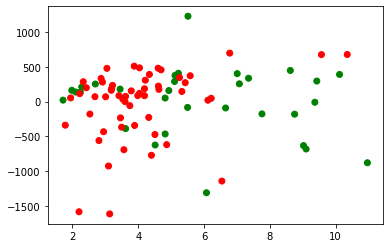

In [56]:
color= np.where( df_cd['Direction'] == 'Short','red', 'green')

plt.scatter(y=df_cd['PnL'], x = df_cd['atr%'], c= color, )
plt.title('volatility / profitability') #title
plt.xlabel('ATR %')
plt.ylabel("PnL") 
plt.show()


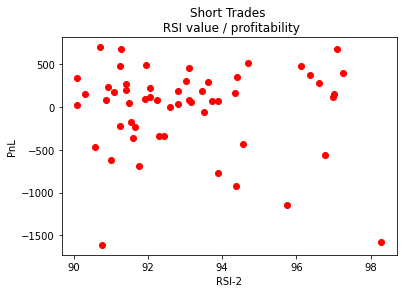

In [61]:
x_filt = df_cd['rsi2'][df_cd['rsi2'] > 90]
y_filt = df_cd['PnL'][df_cd['rsi2'] > 90]

plt.scatter(x=x_filt, y= y_filt, c='red')
plt.title('Short Trades \n RSI value / profitability') #title
plt.xlabel('RSI-2')
plt.ylabel("PnL") 
plt.show()

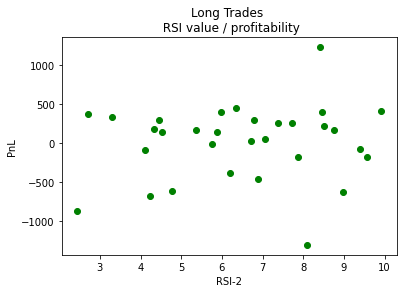

In [64]:
long_x_filt = df_cd['rsi2'][df_cd['rsi2'] < 10]
long_y_filt = df_cd['PnL'][df_cd['rsi2'] < 10]

plt.scatter(x=long_x_filt, y= long_y_filt, c= 'green')
plt.title('Long Trades \n RSI value / profitability') #title
plt.xlabel('RSI-2')
plt.ylabel("PnL")
plt.show()